# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is the csv

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np

## 02 - Load Data and Plot Time Series
Let's start by loading the time series of the challenge and plot the time series

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# load data from CSV file
data = pd.read_csv('data/monthly_champagne_sales.csv')

👉 Convert dataframe with datetime objects as index to make it look like this
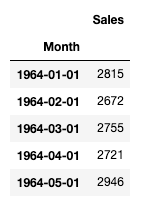

In [3]:
data['Month'] = data.index
data.columns = data.columns.str.replace('Month,"Sales"', 'Sales')
data['Month'] = data['Month'] + '-01'

# Setting the 'Month' column as the index and converting it to a DatetimeIndex object
data = data.set_index(pd.to_datetime(data['Month'], format='%Y-%m-%d'))

# Removing the 'Month' column from the DataFrame
data = data.drop(columns=['Month'])
data

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

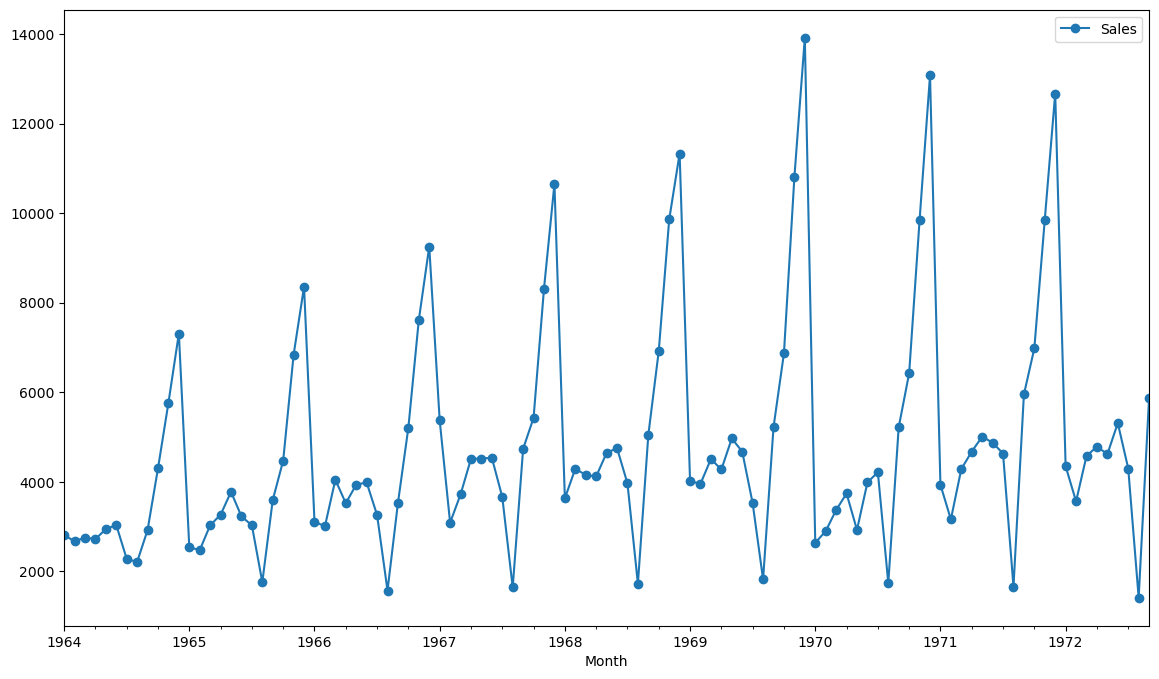

In [4]:
fig, ax = plt.subplots(figsize=(14, 8))
# Plotting the 'Sales' column against the index (i.e., the 'Month' column)
data.plot(kind='line', marker='o', ax=ax)

# Displaying the plot
plt.show()

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

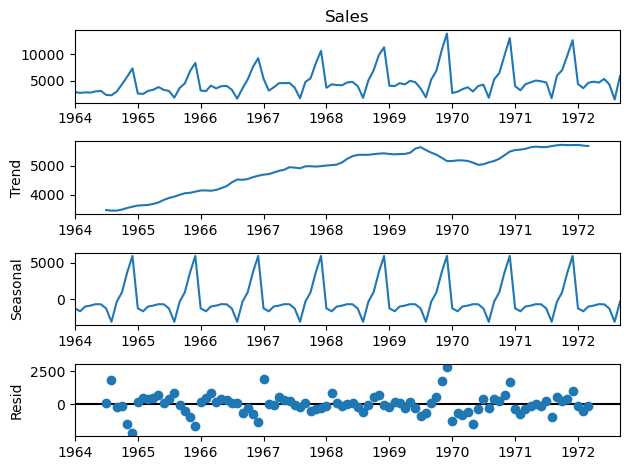

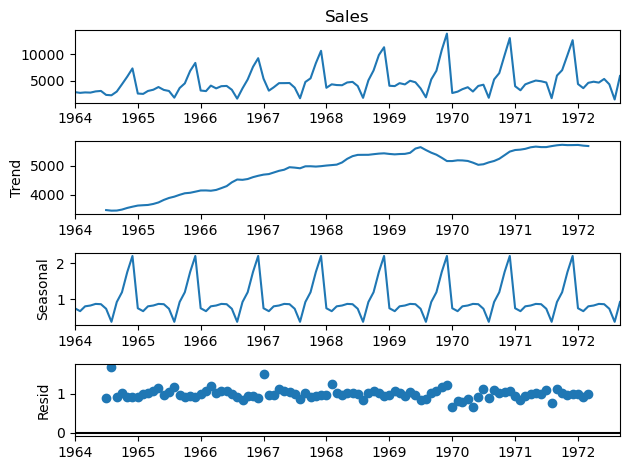

In [5]:
import statsmodels.api as sm

# Decomposing the time series into trend, seasonal, and residual components with additive model
decomp_add_sales = sm.tsa.seasonal_decompose(data['Sales'], model='additive')

# Plotting the decomposed components with additive model
add_plot = decomp_add_sales.plot();


# Decomposing the time series into trend, seasonal, and residual components with multiplicative model
decomp_mult_sales = sm.tsa.seasonal_decompose(data['Sales'], model='multiplicative')

# Plotting the decomposed components with multiplicative model
mult_plot = decomp_mult_sales.plot();

# Displaying the plot
plt.show()

👉 De-seasonalize this time serie using the decomposition of your choice

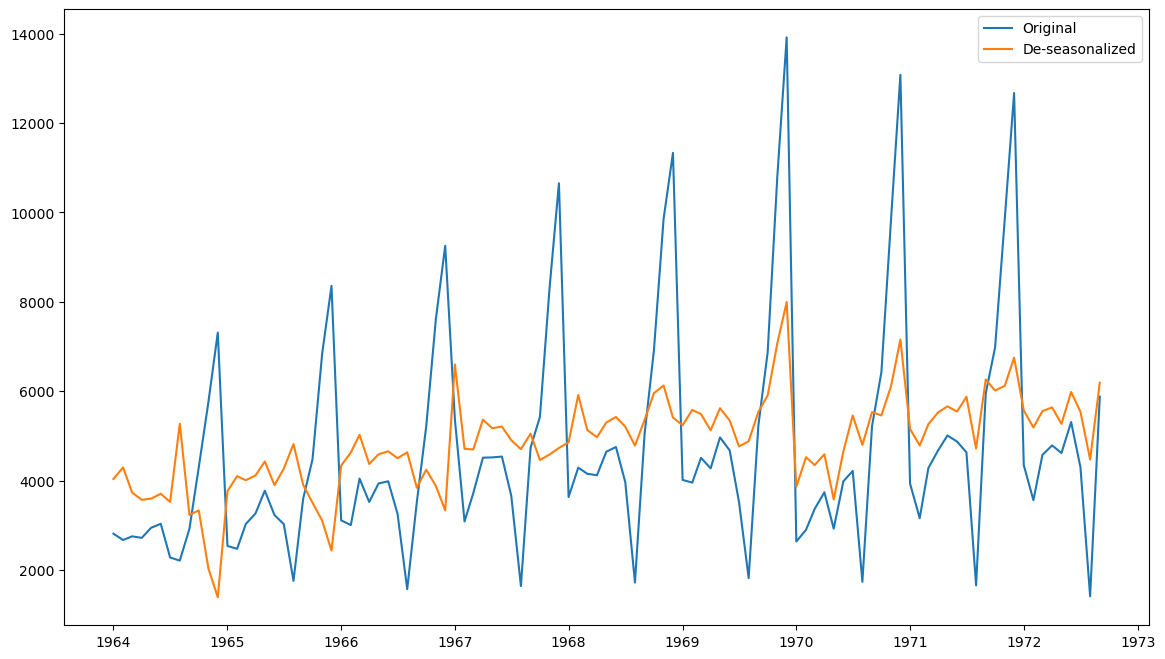

In [6]:
# Decomposing the time series into trend, seasonal, and residual components with additive model
decomp_add_sales = sm.tsa.seasonal_decompose(data['Sales'], model='additive')

# Removing the seasonal component from the time series
sales_deseasonal = data['Sales'] - decomp_add_sales.seasonal

# Plotting the original and de-seasonalized time series
plt.subplots(figsize=(14, 8))
plt.plot(data.index, data['Sales'], label='Original')
plt.plot(sales_deseasonal.index, sales_deseasonal, label='De-seasonalized')
plt.legend(loc='best')
plt.show()

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [7]:
# Splitting data into training and testing sets
data_train = data.loc[:'1969-12']
data_test = data.loc['1970-01':]
data_train

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1969-08-01,1821
1969-09-01,5222
1969-10-01,6872


## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [8]:
# Perform ADF test on the 'Sales' column of the original DataFrame
adf_test = sm.tsa.adfuller(data['Sales'])

# Print the test statistic, p-value, and other test results
print('ADF Test Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])
print('\nADF Test:', adf_test)

ADF Test Statistic: -1.8335930563276195
p-value: 0.3639157716602467
Critical Values: {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}

ADF Test: (-1.8335930563276195, 0.3639157716602467, 11, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 1478.4633060594724)


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

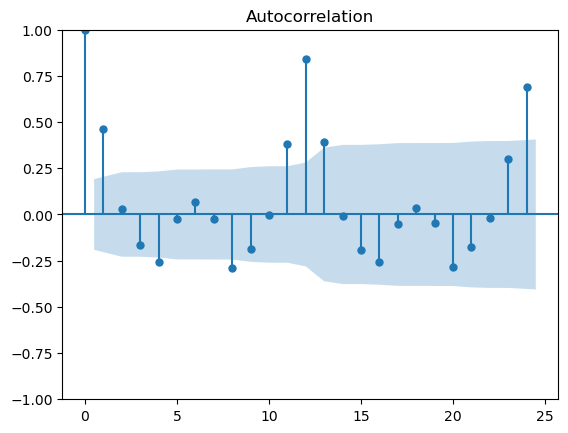

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF of the 'Sales' column
plot_acf(data['Sales'], lags=24)
plt.show()

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

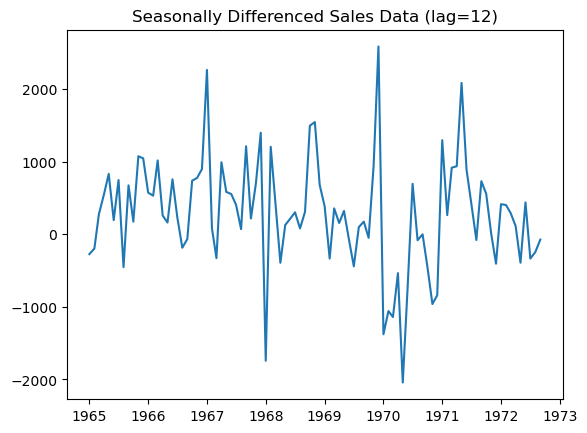

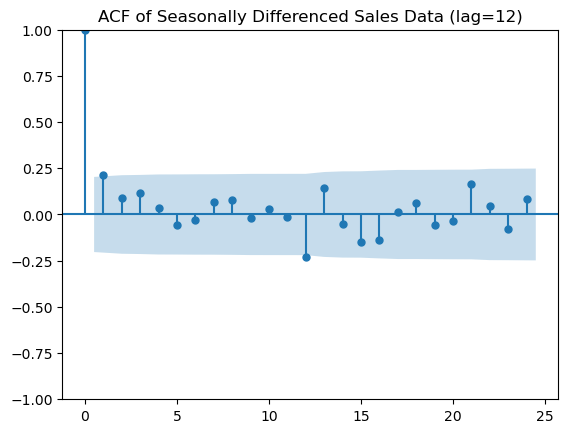

ADF Statistic: -7.626619157213166
p-value: 2.0605796968136632e-11


In [10]:
from statsmodels.tsa.stattools import adfuller

# Seasonal differencing with a lag of 12 + drop NaN's
data_diff = data['Sales'].diff(12).dropna()

# Plot the differenced data
plt.plot(data_diff)
plt.title('Seasonally Differenced Sales Data (lag=12)')
plt.show()

# Check the ACF plot and ADF test of the differenced data
plot_acf(data_diff, lags=24)
plt.title('ACF of Seasonally Differenced Sales Data (lag=12)')
plt.show()

adf_result = adfuller(data_diff)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

In [11]:
plot_acf(data_diff2.diff(1).dropna());

NameError: name 'data_diff2' is not defined

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

In [ ]:
plot_acf(data_diff2)
plot_pacf(data_diff2)
plt.show()

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [ ]:
from pmdarima.arima import auto_arima

# Define the ARIMA model parameters
seasonal_order = (0, 1, 0, 12)  # (P, D, Q, m)
max_order = (2, 1, 2)  # (p, d, q)

# Fit an ARIMA model using auto_arima
model = auto_arima(data_train, seasonal=True, m=12, D=1,
                   start_p=0, start_q=0, max_p=2, max_q=2, 
                   start_P=0, start_Q=0, max_P=2, max_Q=2,
                   max_order=max_order, seasonal_order=seasonal_order,
                   error_action='ignore', suppress_warnings=True,
                   n_jobs=-1, trace=True)

# Print the model summary
print(model.summary())

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [ ]:
n_periods = len(data_test)
fc, indc =model.predict(n_periods=n_periods, return_conf_int=True)
forecast = pd.Series(fc, index=df_test.index)
central = forecast
upper = pd.Series(indc[:, 1], index=df_test.index)
lower = pd.Series(indc[:, 0], index=df_test.index)

👇 Run the cell below to plot your predictions against reality

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label = "train values")
plt.plot(data_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

# Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [ ]:
# Add lagged values
for i in range(1,13):
    data[f'shifted{i}']= data['Sales'].shift(periods=i)

# Drop nan
data = data.dropna()
#create df_train and df_test 
data_train = data.loc[:'1969-12']
data_test = data.loc['1970':]

In [ ]:
# Keep track of test_indexes
test_index = data_test.reset_index() 
test_indexes = test_index.index + 1
print(test_indexes)

In [ ]:
# Create X, y
X_train = data_train.reset_index()
X_train.drop(X_train.columns[[0, 1]], axis=1, inplace=True)
y_train = data_train.Sales
X_test = data_test.reset_index()
X_test.drop(X_test.columns[[0, 1]], axis=1, inplace=True)
y_test = data_test.Sales

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

In [ ]:
rf = RandomForestRegressor(max_depth=2, random_state=0)

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [ ]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(y_train, test_indexes=test_indexes,
                                                         predictor=rf, full_X = X_train)

In [ ]:
print('Mean Absolute Prediction Error MAPE')
results[2]

In [ ]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [ ]:
# Extract the trend using a well chosen moving average

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

You should see a better MAPE!

Try to look at the importance of each feature. What do you find?


### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA